STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
# %load_ext watermark
# %watermark -a 'Sebastian Raschka' -v -p torch

ModuleNotFoundError: No module named 'watermark'

- Runs on CPU or GPU (if available)

# Softmax Regression on MNIST

Implementation of softmax regression (multinomial logistic regression).

## Imports

In [2]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

True


## Settings and Dataset

In [41]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 25
batch_size = 32

# Architecture
num_features = 1024
num_classes = 10


##########################
### CIFAR-10 DATASET
##########################

my_transforms = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(1)])

train_dataset = datasets.CIFAR10(root='data',
                               train=True, 
                               transform=my_transforms,
                               download=True)

test_dataset = datasets.CIFAR10(root='data',
                              train=False, 
                              transform=my_transforms)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([32, 1, 32, 32])
Image label dimensions: torch.Size([32])


In [42]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [43]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 32*32).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 32*32).to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))


epoch_costs = torch.as_tensor(epoch_costs)


Epoch: 001/025 | Batch 000/1562 | Cost: 2.3026
Epoch: 001/025 | Batch 050/1562 | Cost: 2.3333
Epoch: 001/025 | Batch 100/1562 | Cost: 2.2571
Epoch: 001/025 | Batch 150/1562 | Cost: 2.3058
Epoch: 001/025 | Batch 200/1562 | Cost: 2.2419
Epoch: 001/025 | Batch 250/1562 | Cost: 2.2210
Epoch: 001/025 | Batch 300/1562 | Cost: 2.2200
Epoch: 001/025 | Batch 350/1562 | Cost: 2.2358
Epoch: 001/025 | Batch 400/1562 | Cost: 2.2237
Epoch: 001/025 | Batch 450/1562 | Cost: 2.2310
Epoch: 001/025 | Batch 500/1562 | Cost: 2.1992
Epoch: 001/025 | Batch 550/1562 | Cost: 2.1750
Epoch: 001/025 | Batch 600/1562 | Cost: 2.1658
Epoch: 001/025 | Batch 650/1562 | Cost: 2.1881
Epoch: 001/025 | Batch 700/1562 | Cost: 2.2227
Epoch: 001/025 | Batch 750/1562 | Cost: 2.2567
Epoch: 001/025 | Batch 800/1562 | Cost: 2.2097
Epoch: 001/025 | Batch 850/1562 | Cost: 2.1073
Epoch: 001/025 | Batch 900/1562 | Cost: 2.2026
Epoch: 001/025 | Batch 950/1562 | Cost: 2.2314
Epoch: 001/025 | Batch 1000/1562 | Cost: 2.1579
Epoch: 001/0

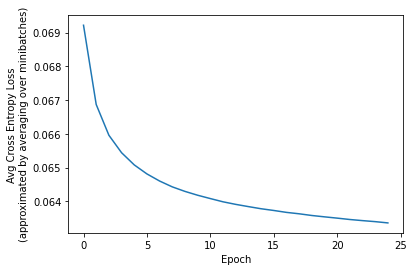

In [46]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [47]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 29.18%


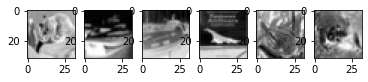

In [48]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 6)
for i in range(6):
    ax[i].imshow(features[i].view(32, 32), cmap=matplotlib.cm.binary)

plt.show()

In [49]:
_, predictions = model.forward(features[:6].view(-1, 32*32).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)
print('Ground Truth labels', labels[0:6])

Predicted labels tensor([0, 9, 8, 8, 3, 6], device='cuda:0')
Ground Truth labels tensor([9, 9, 7, 9, 8, 4])


In [50]:
torch.save(model.state_dict(), "cifar10_softwmaxRegression.pth")

In [51]:
# It seems as though as we decrease the minibatch size, the accuracy increases slightly and that Average cross entropy loss increases as well. However, what is interesting is that the graph displaying the average cross entropy loss is much smoother, signifying a decrease in loss that is greater at first, but then as each epoch goes by, it gets to a minimum loss. Also, as the minibatch size decreases, the more time the model will take to train.